In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import datetime as dt
import heapq 

In [211]:
# loading data
path = r"Data\AAPL_options.csv"
options_df = pd.read_csv(path, parse_dates=["date", "expiration date"])

In [212]:
# standardizing column naming 
options_df.columns = [x.lower().replace(" ", "_") for x in options_df.columns]
original_options_df = options_df.copy()

In [213]:
# concatenating call and put rows for the same price    
# call mid, put mid are columns 16 and 17 respectively
options_df["call_bid"] = 0
options_df["put_bid"] = 0
options_df["call_ask"] = 0 
options_df["put_ask"] = 0
options_df["call_open_interest"] = 0
options_df["put_open_interest"] = 0
options_df["call_volume"] = 0
options_df["put_volume"] = 0
options_df["call_bid_size"] = 0
options_df["put_bid_size"] = 0
options_df["call_ask_size"] = 0
options_df["put_ask_size"] = 0
    
# boolean masks for call and put options in every second row
call_mask = (options_df.iloc[::2, 2] == "call").values
put_mask = (options_df.iloc[::2, 2] == "put").values

# indices of every second row
indices = np.arange(0, options_df.shape[0], 2)

In [214]:
def line_break(index):
        if index % 6 == 0 and index != 0:
            return None
        else: 
            return " "

for idx, i in enumerate(options_df.columns):
    print(f"{idx}: {i},", end=line_break(idx))

0: date, 1: expiration_date, 2: type, 3: strike_price, 4: ask_price, 5: ask_size, 6: bid_price,
7: bid_size, 8: last_price, 9: volume, 10: open_interest, 11: closing_price, 12: exp_closing_price,
13: date_div, 14: exp_date_div, 15: call_bid, 16: put_bid, 17: call_ask, 18: put_ask,
19: call_open_interest, 20: put_open_interest, 21: call_volume, 22: put_volume, 23: call_bid_size, 24: put_bid_size,
25: call_ask_size, 26: put_ask_size, 

In [215]:
len(options_df.columns)

27

In [216]:
assignment_list = ["bid_price", "bid_price", "ask_price", "ask_price",
                   "open_interest", "open_interest", "volume", "volume", 
                   "bid_size", "bid_size", "ask_size", "ask_size"]

for i in range(15, len(options_df.columns)-1):
    # call value assignment based on call mask
    options_df.iloc[indices[call_mask], i] = options_df.iloc[indices[call_mask], list(options_df.columns).index(assignment_list[i-15])]
    # put value assignment based on call mask
    options_df.iloc[indices[call_mask], i + 1] = options_df.iloc[indices[call_mask] + 1, list(options_df.columns).index(assignment_list[i-15])]

    # put value assignment based on put mask
    options_df.iloc[indices[put_mask], i + 1] = options_df.iloc[indices[put_mask], list(options_df.columns).index(assignment_list[i-15])]
    # call value assignment based on put mask
    options_df.iloc[indices[put_mask], i] = options_df.iloc[indices[put_mask] + 1, list(options_df.columns).index(assignment_list[i-15])]

C:\Users\hollanderj\AppData\Local\Temp\ipykernel_6312\2168356756.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[11.3     5.05    2.325  ...  5.375   4.75    0.4875]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  options_df.iloc[indices[call_mask], i] = options_df.iloc[indices[call_mask], list(options_df.columns).index(assignment_list[i-15])]
C:\Users\hollanderj\AppData\Local\Temp\ipykernel_6312\2168356756.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00000e+00 2.50000e-03 1.75000e-02 ... 2.80000e+00 3.27500e+00
 1.46625e+01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  options_df.iloc[indices[call_mask], i + 1] = options_df.iloc[indices[call_mask] + 1, list(options_df.columns).index(assignment_list[i-15])]
C:\Users\hollan

In [217]:
# reducing rows to every other and fixing index
options_df = options_df[options_df.index % 2 == 0]
options_df.index = np.arange(0, len(options_df))

In [218]:
# combining open interest and volume
options_df["combined_oi"] = options_df["call_open_interest"] + options_df["put_open_interest"]
options_df["combined_volume"] = options_df["call_volume"] + options_df["put_volume"]

In [219]:
# creating DTE
T = (options_df["expiration_date"] - options_df["date"]).dt.days
options_df["DTE"] = T

In [220]:
options_df.iloc[0, :-3]

date                  2016-01-04 00:00:00
expiration_date       2016-01-08 00:00:00
type                                 call
strike_price                         15.0
ask_price                          11.375
ask_size                             20.0
bid_price                            11.3
bid_size                             12.0
last_price                            0.0
volume                                0.0
open_interest                         0.0
closing_price                      26.337
exp_closing_price                   24.24
date_div                         0.085246
exp_date_div                      0.09377
call_bid                             11.3
put_bid                              11.3
call_ask                           11.375
put_ask                            11.375
call_open_interest                    0.0
put_open_interest                       0
call_volume                             0
put_volume                              0
call_bid_size                     

In [221]:
# new df with just call columns
call_columns_to_keep = ["date", "expiration_date", "strike_price", 
                        "closing_price", "call_bid", "call_ask", "call_bid_size",
                        "call_ask_size", "call_open_interest", "call_volume", "DTE"]
call_df = options_df[call_columns_to_keep]
call_df.head(1)

,date,expiration_date,strike_price,closing_price,call_bid,call_ask,call_bid_size,call_ask_size,call_open_interest,call_volume,DTE
0,2016-01-04,2016-01-08,15.0,26.337,11.3,11.375,12,20,0.0,0,4


In [222]:
# new df with just put columns
put_columns_to_keep = ["date", "expiration_date", "strike_price", 
                        "closing_price", "put_bid", "put_ask", "put_bid_size",
                        "put_ask_size", "put_open_interest", "put_volume", "DTE"]
put_df = options_df[put_columns_to_keep]
put_df.head(1)

,date,expiration_date,strike_price,closing_price,put_bid,put_ask,put_bid_size,put_ask_size,put_open_interest,put_volume,DTE
0,2016-01-04,2016-01-08,15.0,26.337,11.3,11.375,12,1400,0,0,4


In [223]:
# removing unwanted (empty) bids and asks from calls and puts
call_bid_mask = (call_df["call_bid"] > 0) & (call_df["call_bid_size"] > 0) 
call_ask_mask = (call_df["call_ask"] > 0) & (call_df["call_ask_size"] > 0 )
call_df = call_df[call_bid_mask]

put_bid_mask = (put_df["put_bid"] > 0) & (put_df["put_bid_size"] > 0)
put_ask_mask = (put_df["put_ask"] > 0) & (put_df["put_ask_size"] > 0)
put_df = put_df[put_bid_mask]

In [224]:
len(call_df), len(put_df)

(136350, 136350)

In [225]:
def organize_by_dates(old_df, columns, df):
    for header in columns:
        df[header] = old_df.groupby("date")[header].apply(np.array)
    
    df["terms"] = df["DTE"].apply(lambda x: sorted(set(x)))
    return df

call_date_df = organize_by_dates(options_df, call_df.columns[call_df.columns != "date"], pd.DataFrame())
put_date_df = organize_by_dates(options_df, put_df.columns[put_df.columns != "date"], pd.DataFrame())

In [226]:
# make closing price one value
call_date_df["closing_price"] = list(map(lambda x: np.array(x)[0], call_date_df["closing_price"]))
put_date_df["closing_price"] = list(map(lambda x: np.array(x)[0], put_date_df["closing_price"]))

In [227]:
call_date_df.head(1)

,expiration_date,strike_price,closing_price,call_bid,call_ask,call_bid_size,call_ask_size,call_open_interest,call_volume,DTE,terms
date,,,,,,,,,,,
2016-01-04,"[2016-01-08T00:00:00.000000000, 2016-01-08T00:...","[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, ...",26.337,"[11.3, 10.05, 8.8, 7.55, 6.3, 5.05, 3.8, 3.562...","[11.375, 10.125, 8.875, 7.625, 6.375, 5.1075, ...","[12, 12, 20, 20, 80, 196, 2644, 100, 128, 128,...","[20, 20, 20, 20, 76, 24, 1848, 72, 56, 68, 44,...","[0.0, 0.0, 0.0, 0.0, 4.0, 8.0, 972.0, 0.0, 0.0...","[0, 0, 0, 0, 0, 0, 52, 0, 4, 0, 0, 324, 88, 44...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,..."


In [245]:
def sum_based_on_dte(row, cutoff=7, col="call_volume"):
    idx = np.arange(0, len(row.loc["DTE"]))[np.array(row.loc["DTE"]) <= cutoff]
    return np.sum(np.array(row.loc[col])[idx])

def sum_based_on_moneyness(row, col="call_volume", call=True, otm=True, pct=None):
    if pct:
        value = np.quantile(row["strike_price"], pct)
    else:
        value = float(row["closing_price"])
    if call != otm:  
       indexer = np.array(row["strike_price"]) < value
    else:
        indexer = np.array(row["strike_price"]) > value
        
    idx = np.arange(0, len(row["strike_price"]))[indexer]
    return np.sum(np.array(row[col])[idx])

def sum_based_on_both(row, cutoff=7, col="call_volume", call=True, otm=True, pct=None):
    if pct:
        value = np.quantile(row["strike_price"], pct)
    else:
        value = float(row["closing_price"])
    if call != otm:  
        moneyness_indexer = np.array(row["strike_price"]) < value 
    else:
        moneyness_indexer = np.array(row["strike_price"]) > value

    dte_indexer = np.array(row["DTE"]) <= cutoff
    indexer = moneyness_indexer & dte_indexer
    idx = np.arange(0, len(row["strike_price"]))[indexer]
    return np.sum(np.array(row[col])[idx])

def flow_otm_low_dte(row, cutoff=7, call=True, otm=True, pct=None):
    if pct:
        value = np.quantile(row["strike_price"], pct)
    else:
        value = float(row["closing_price"])
    if call != otm:  
        moneyness_indexer = np.array(row["strike_price"]) < value 
    else:
        moneyness_indexer = np.array(row["strike_price"]) > value
    
    dte_indexer = np.array(row["DTE"]) <= cutoff
    indexer = moneyness_indexer & dte_indexer
    idx = np.arange(0, len(row["strike_price"]))[indexer]
    return np.sum((np.array(row["call_bid_size"]) - np.array(row["call_ask_size"]))[idx])
        
    
print(sum_based_on_dte(call_date_df.iloc[0, :], 7))
print(sum_based_on_moneyness(call_date_df.iloc[0, :]), sum_based_on_moneyness(call_date_df.iloc[0, :], otm=False))
print(sum_based_on_both(call_date_df.iloc[0, :]))
print(flow_otm_low_dte(call_date_df.iloc[0, :]))


555972
1556900 687448
300492
-13916


In [244]:
call_date_df.head(1)

,expiration_date,strike_price,closing_price,call_bid,call_ask,call_bid_size,call_ask_size,call_open_interest,call_volume,DTE,terms
date,,,,,,,,,,,
2016-01-04,"[2016-01-08T00:00:00.000000000, 2016-01-08T00:...","[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, ...",26.337,"[11.3, 10.05, 8.8, 7.55, 6.3, 5.05, 3.8, 3.562...","[11.375, 10.125, 8.875, 7.625, 6.375, 5.1075, ...","[12, 12, 20, 20, 80, 196, 2644, 100, 128, 128,...","[20, 20, 20, 20, 76, 24, 1848, 72, 56, 68, 44,...","[0.0, 0.0, 0.0, 0.0, 4.0, 8.0, 972.0, 0.0, 0.0...","[0, 0, 0, 0, 0, 0, 52, 0, 4, 0, 0, 324, 88, 44...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,..."


In [ ]:
volume_series = call_date_df.apply(lambda x: sum_based_on_both(x, pct=0.75), axis=1).diff() 
volume_series = (volume_series - volume_series.mean())/volume_series.std()

oi_series = call_date_df.apply(lambda x: sum_based_on_both(x, col="call_open_interest", pct=0.75), axis=1).diff()
oi_series = (oi_series - oi_series.mean())/oi_series.std()

volume_increase_index = np.array(volume_series) > 0
plot_series = (oi_diff_series * volume_diff_series)[np.arange(len(volume_diff_series))[volume_diff_increase_index]]

In [249]:
volume_diff_series = call_date_df.apply(lambda x: sum_based_on_both(x, pct=0.75), axis=1).diff() - \
    call_date_df.apply(lambda x: sum_based_on_both(x, pct=0.5, otm=False), axis=1)
volume_diff_series = (volume_diff_series - volume_diff_series.mean())/volume_diff_series.std()

oi_diff_series = call_date_df.apply(lambda x: sum_based_on_both(x, col="call_open_interest", pct=0.75), axis=1).diff() - \
    call_date_df.apply(lambda x: sum_based_on_both(x, col="call_open_interest", pct=0.5, otm=False), axis=1)
oi_diff_series = (oi_diff_series - oi_diff_series.mean())/oi_diff_series.std()

volume_diff_increase_index = np.array(volume_diff_series) > 0
diff_plot_series = (oi_diff_series * volume_diff_series)[np.arange(len(volume_diff_series))[volume_diff_increase_index]]

C:\Users\hollanderj\AppData\Local\Temp\ipykernel_6312\2404271661.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff_plot_series = (oi_diff_series * volume_diff_series)[np.arange(len(volume_diff_series))[volume_diff_increase_index]]


In [250]:
# rsi
def rma(x, n):
        """Running moving average"""
        a = np.full_like(x, np.nan)
        a[n] = x[1:n+1].mean()
        for i in range(n+1, len(x)):
            a[i] = (a[i-1] * (n - 1) + x[i]) / n
        return a

def rsi(price_series):
    change = price_series.diff()
    gain = change.mask(change < 0, 0.0)
    loss = -change.mask(change > 0, -0.0)
    
    avg_gain = rma(gain.to_numpy(), 14)
    avg_loss = rma(loss.to_numpy(), 14)

    rs = avg_gain/avg_loss
    return 100 - (100 / (1 + rs))

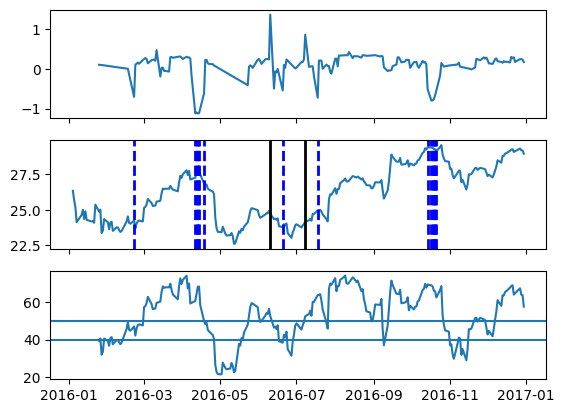

In [252]:
figggg, axxxx = plt.subplots(3, sharex=True)

pos_spike_idx = np.arange(len(diff_plot_series))[diff_plot_series > 0.5]
neg_spike_idx = np.arange(len(diff_plot_series))[diff_plot_series < -0.5]

rsi_arr = rsi(call_date_df["closing_price"])#[volume_diff_increase_index]
#pos_spike_idx = pos_spike_idx[rsi_arr[pos_spike_idx] <= 50]
#neg_spike_idx = neg_spike_idx[rsi_arr[neg_spike_idx] >= 30]

axxxx[0].plot(diff_plot_series)
axxxx[1].plot(call_date_df["closing_price"])
for i in pos_spike_idx:
    axxxx[1].axvline(diff_plot_series.index[i], color="black", linewidth=2)
for i in neg_spike_idx:
    axxxx[1].axvline(diff_plot_series.index[i], color="blue", linestyle="--", linewidth=2)

axxxx[2].plot(call_date_df["closing_price"].index, rsi_arr)
axxxx[2].axhline(50)
axxxx[2].axhline(40)